In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
from scipy.ndimage.measurements import label


In [2]:
# Load the classifier and parameters
data_file = 'ClassifierData.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']
color_space = data['color_space']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']
hog_channel = data['hog_channel']
spatial_feat = data ['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']

In [3]:
images = sorted(glob.glob('test_images/out*.png'))
#images

In [4]:
#image = mpimg.imread('bbox-example-image.png')
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

def search_all_scales(image):
    
    hot_windows = []
    all_windows = []
    #Y_start_stop =[[300,460]]
    #XY_window = [(150,150)]
    #X_start_stop =[[None,None]]    
    #X_start_stop =[[None,None],[None,None],[None,None]]    
    #Y_start_stop =[[390,440],[400,560],[400,560]]    
    #XY_window = [(80,80),(110,110),(130,130)]

    X_start_stop =[[None,None],[None,None]]    
    Y_start_stop =[[390,470],[390,500]]    
    XY_window = [(64,64),(110,110)]
    XY_overlap=[(0.75, 0.75),(0.75, 0.75)]

    X_start_stop =[[None,None],[None,None],[None,None],[None,None]]
    w0,w1,w2,w3 = 240,180,120,70
    o0,o1,o2,o3 = 0.75,0.75,0.75,0.75
    XY_window = [(w0,w0),(w1,w1),(w2,w2),(w3,w3)]
    XY_overlap = [(o0,o0),(o1,o1),(o2,o2),(o3,o3)]
    yi0,yi1,yi2,yi3 = 380,380,395,405                  
    Y_start_stop =[[yi0,yi0+w0/2],[yi1,yi1+w1/2],[yi2,yi2+w2/2],[yi3,yi3+w3/2]]    
    
    
    
    for i in range(len(Y_start_stop)):
        windows = slide_window(image, x_start_stop=X_start_stop[i], y_start_stop=Y_start_stop[i], 
                            xy_window=XY_window[i], xy_overlap=XY_overlap[i])
        
        all_windows += [windows]        
        
        hot_windows +=  search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    return hot_windows,all_windows

0.51 Seconds to search windows ...


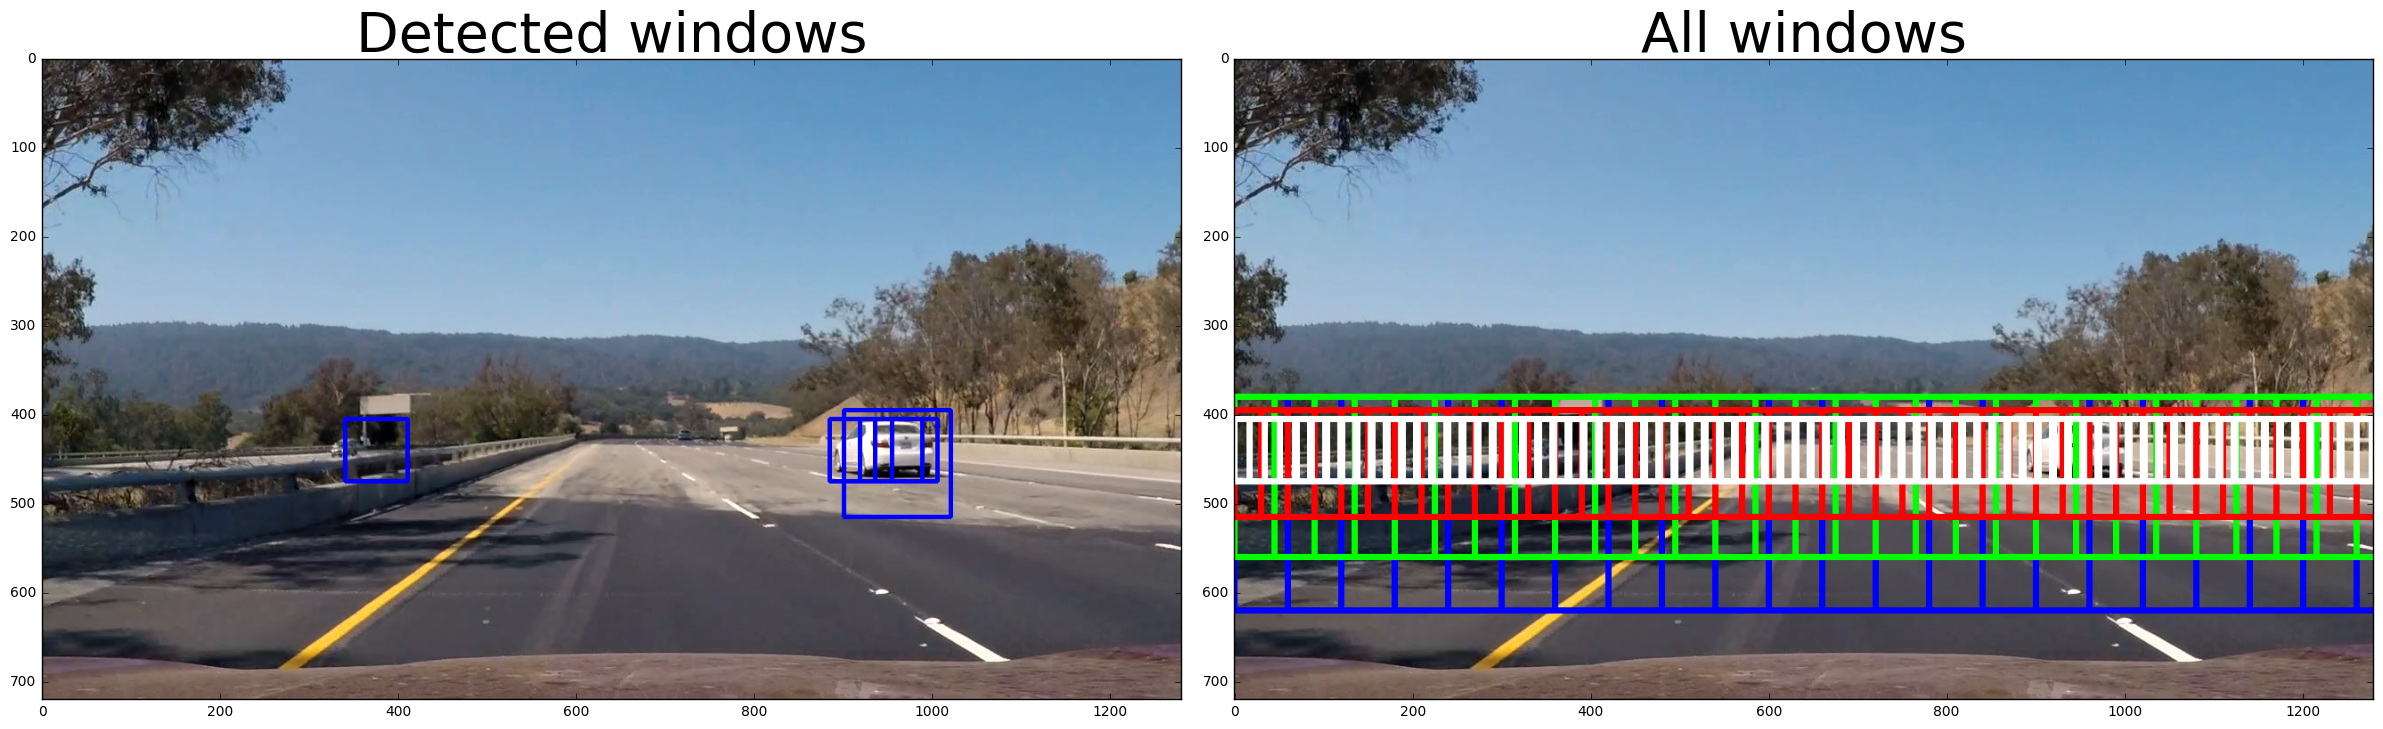

In [5]:
for file in images[43:44]:
    image = mpimg.imread(file)
    #image = image.astype(np.float32)/255
    draw_image = np.copy(image)

    t=time.time()
    hot_windows,all_windows = search_all_scales(image)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to search windows ...')
    #print(np.array(all_windows).shape)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)                    

    
    
    allwindows_img = draw_image
    for ind,win_list in enumerate(all_windows):
        if ind==0: color= (0,0,1)
        if ind==1: color= (0,1,0)
        if ind==2: color= (1,0,0)
        if ind==3: color= (1,1,1)
            
        allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)                    
    
    
    
    plt.figure()    
    # Plot the result
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(window_img)
    ax1.set_title('Detected windows', fontsize=40)

    ax2.imshow(allwindows_img)
    ax2.set_title('All windows', fontsize=40)
    plt.show()
    #plt.savefig('images/sliding_windows.png')

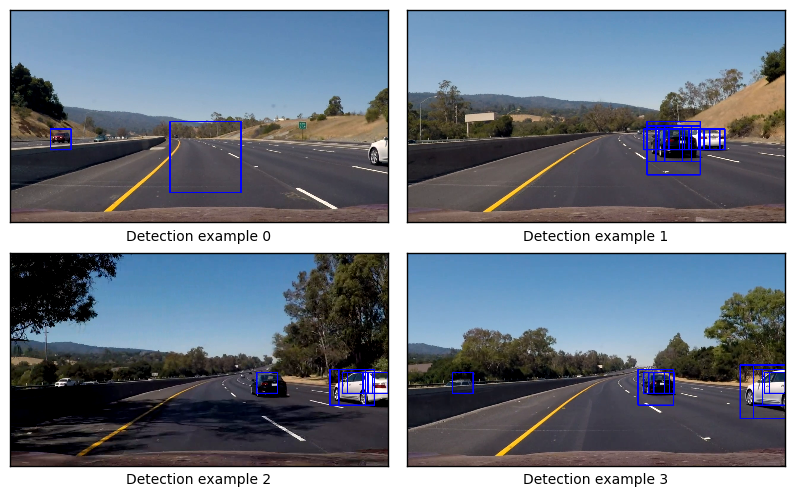

In [6]:
file0 = images[10]
file1 = images[70]
file2 = images[83]
file3 = images[90]

files = [file0,file1,file2,file3]

fig, axes = plt.subplots(2,2,figsize=(10,6))
fig.subplots_adjust(hspace=0.1, wspace=0.05)


for i, ax in enumerate(axes.flat):
    image = mpimg.imread(files[i])
    draw_image = np.copy(image)
    hot_windows,all_windows = search_all_scales(image)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)                    
    ax.imshow(window_img)
    xlabel = "Detection example {0}".format(i)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])     

plt.show()
#plt.savefig('images/detection_example.png')

## Video Pipeline

In [7]:
# Define a class to receive the characteristics of bounding box detections
class BoundingBoxes:
    def __init__(self,n=10):
        # length of queue to store data
        self.n = n
        # hot windows of the last n images
        self.recent_boxes = deque([],maxlen=n)
        # current boxes
        self.current_boxes = None
        self.allboxes = []

    def add_boxes(self):
        self.recent_boxes.appendleft(self.current_boxes)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_boxes.pop()            
    def set_current_boxes(self,boxes):
        self.current_boxes = boxes
        
    def get_all_boxes(self):        
        allboxes = []
        for boxes in self.recent_boxes:
            allboxes += boxes
        if len(allboxes)==0:
            self.allboxes = None
        else:
            self.allboxes = allboxes
            
    def update(self,boxes):
        self.set_current_boxes(boxes)
        self.add_boxes()
        self.get_all_boxes()
                
        
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    if bbox_list:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


0.53 Seconds to search windows ...
0.54 Seconds to search windows ...
0.61 Seconds to search windows ...
0.51 Seconds to search windows ...
0.51 Seconds to search windows ...
0.51 Seconds to search windows ...


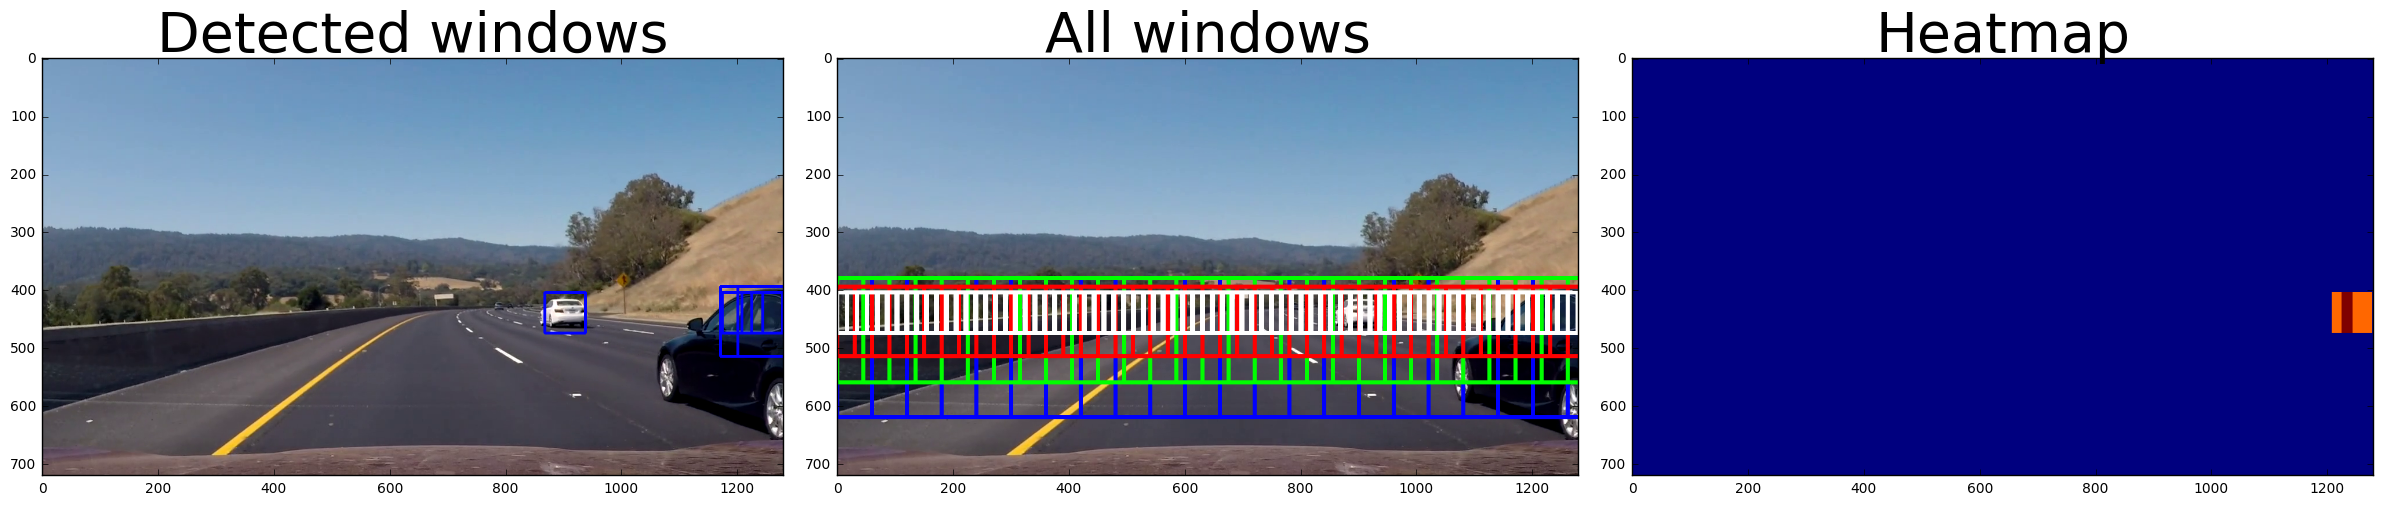

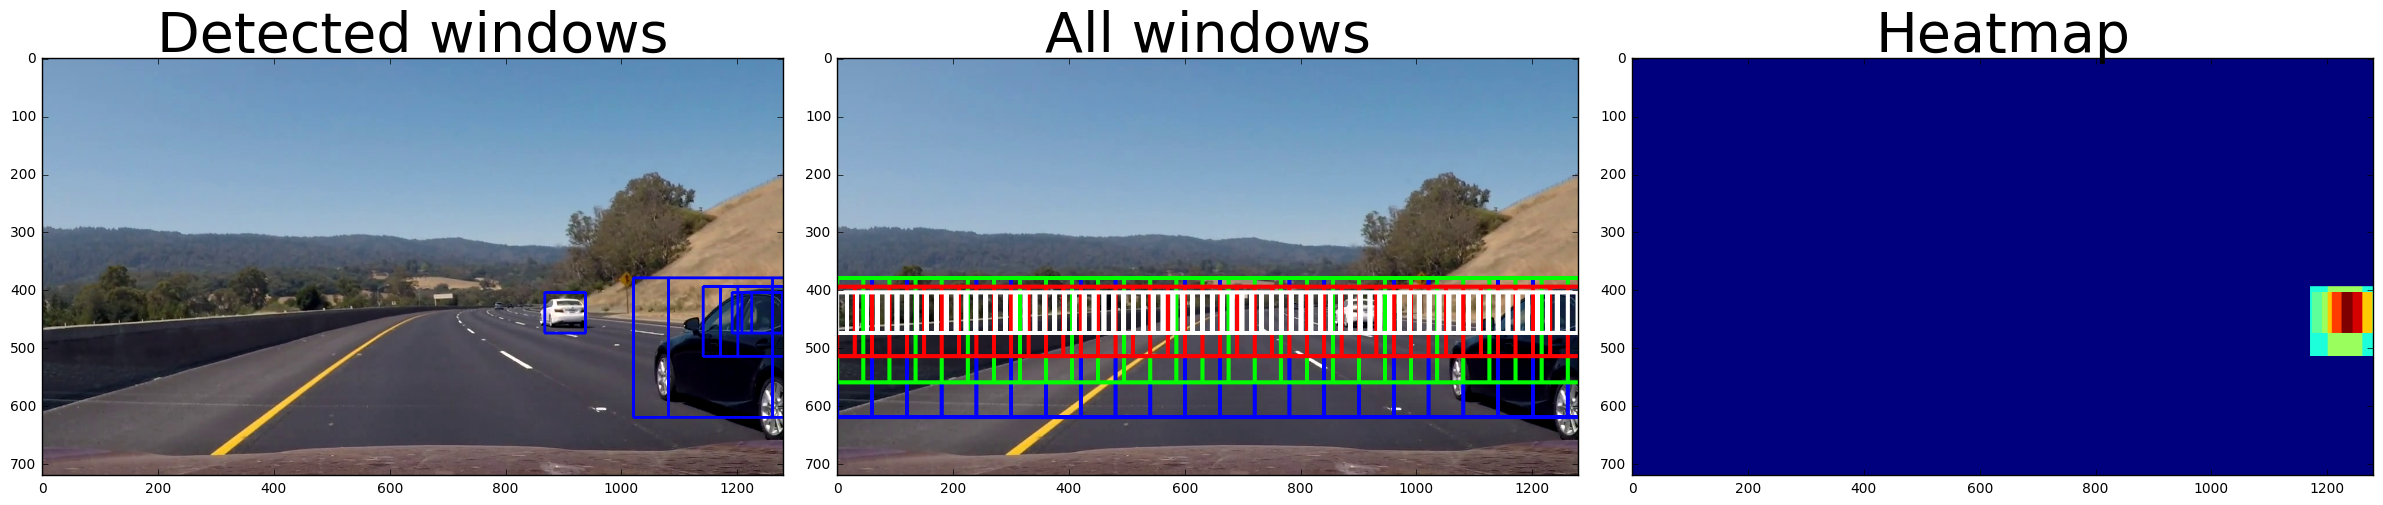

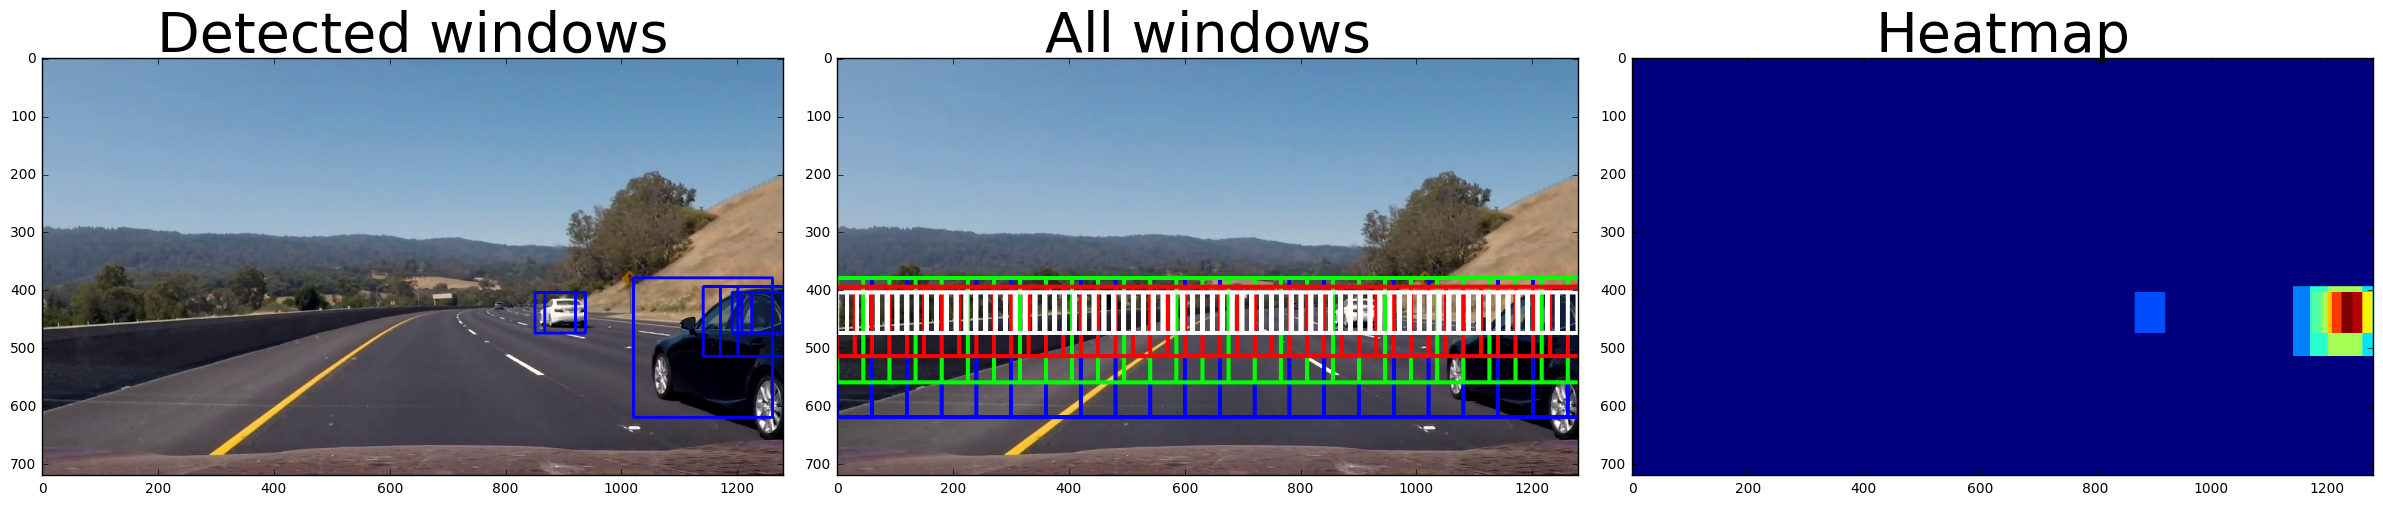

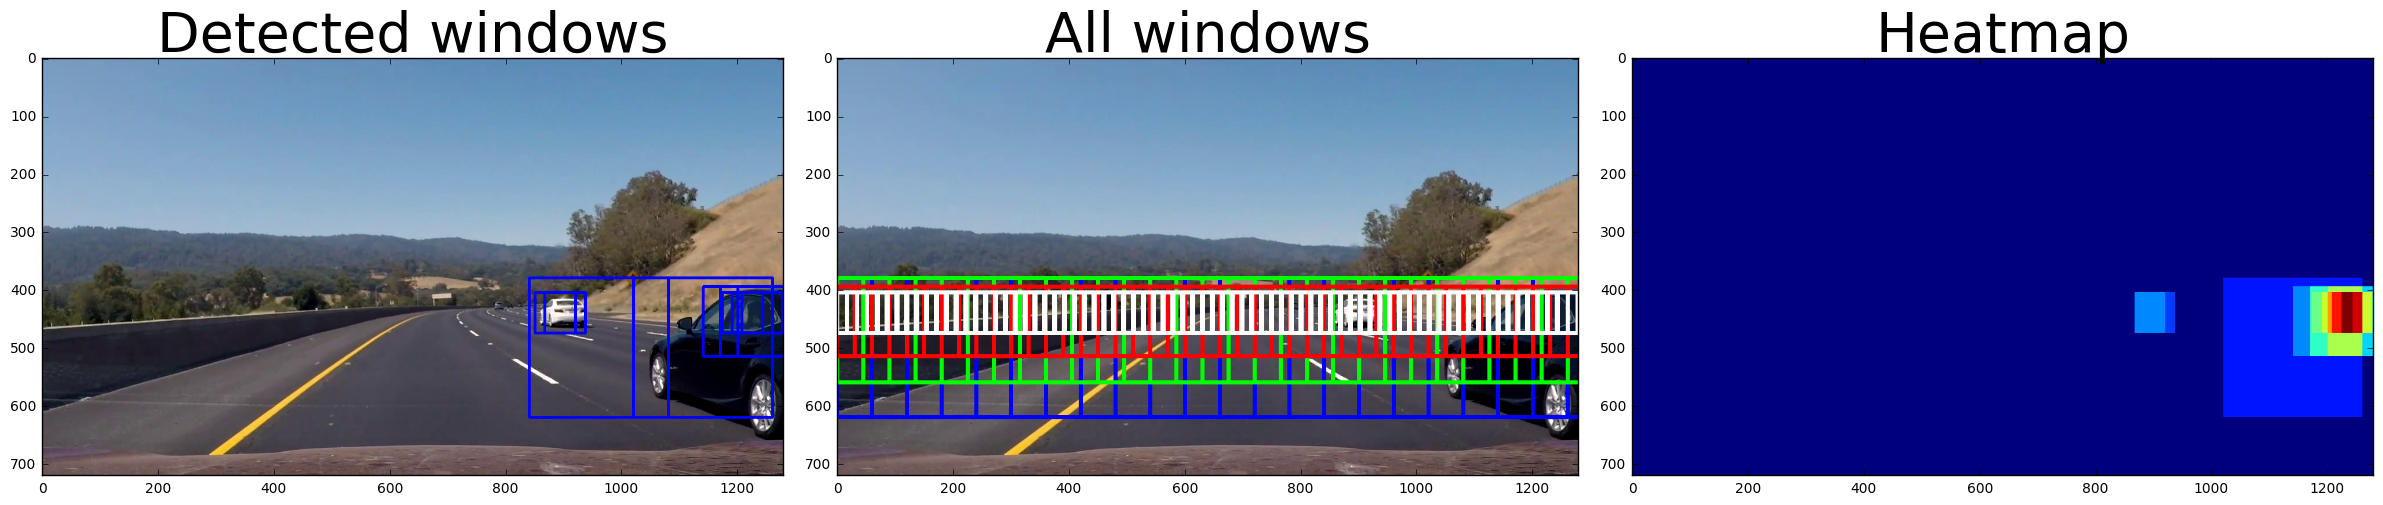

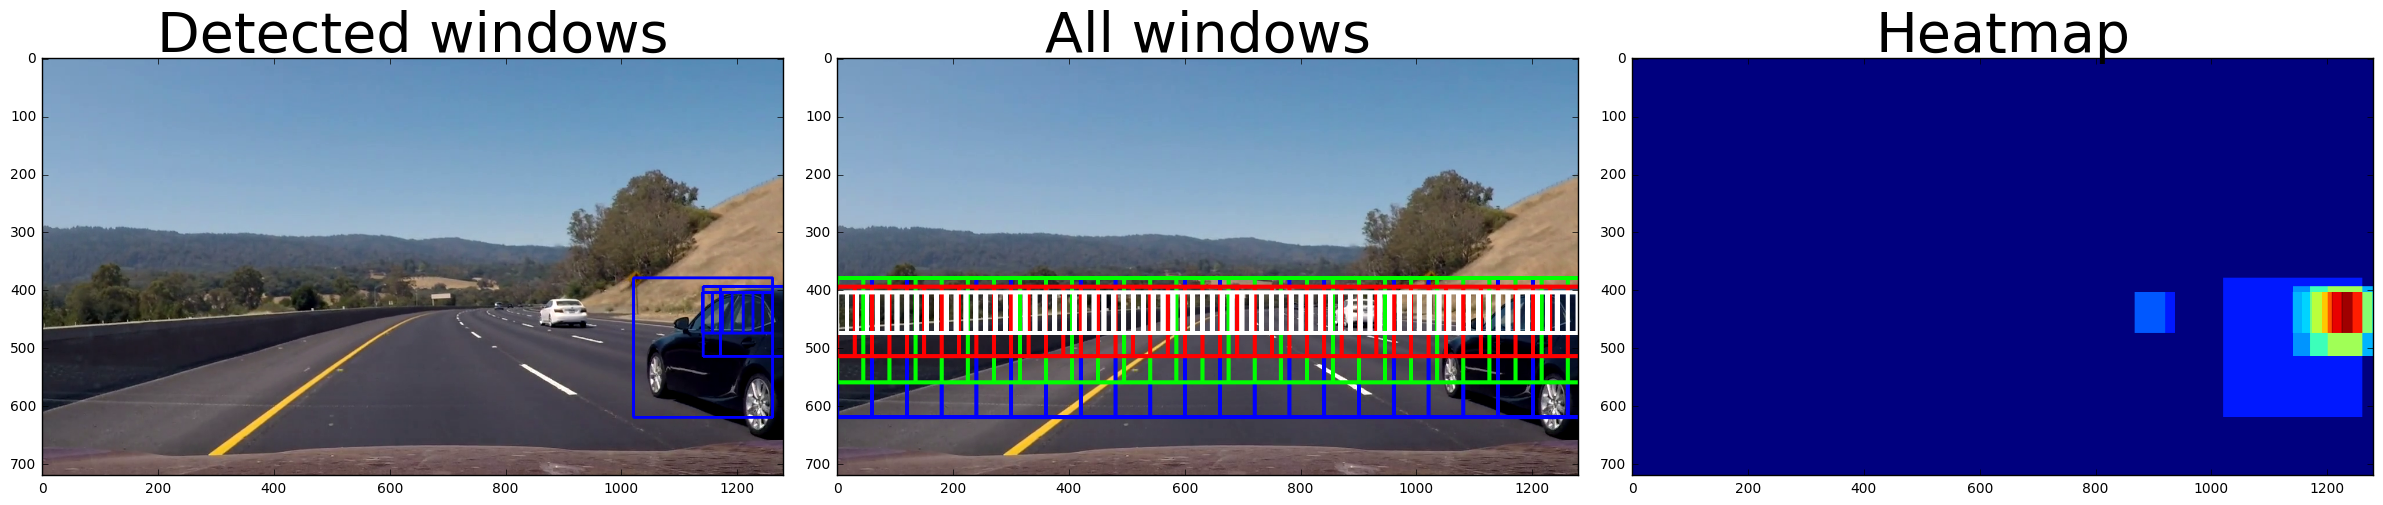

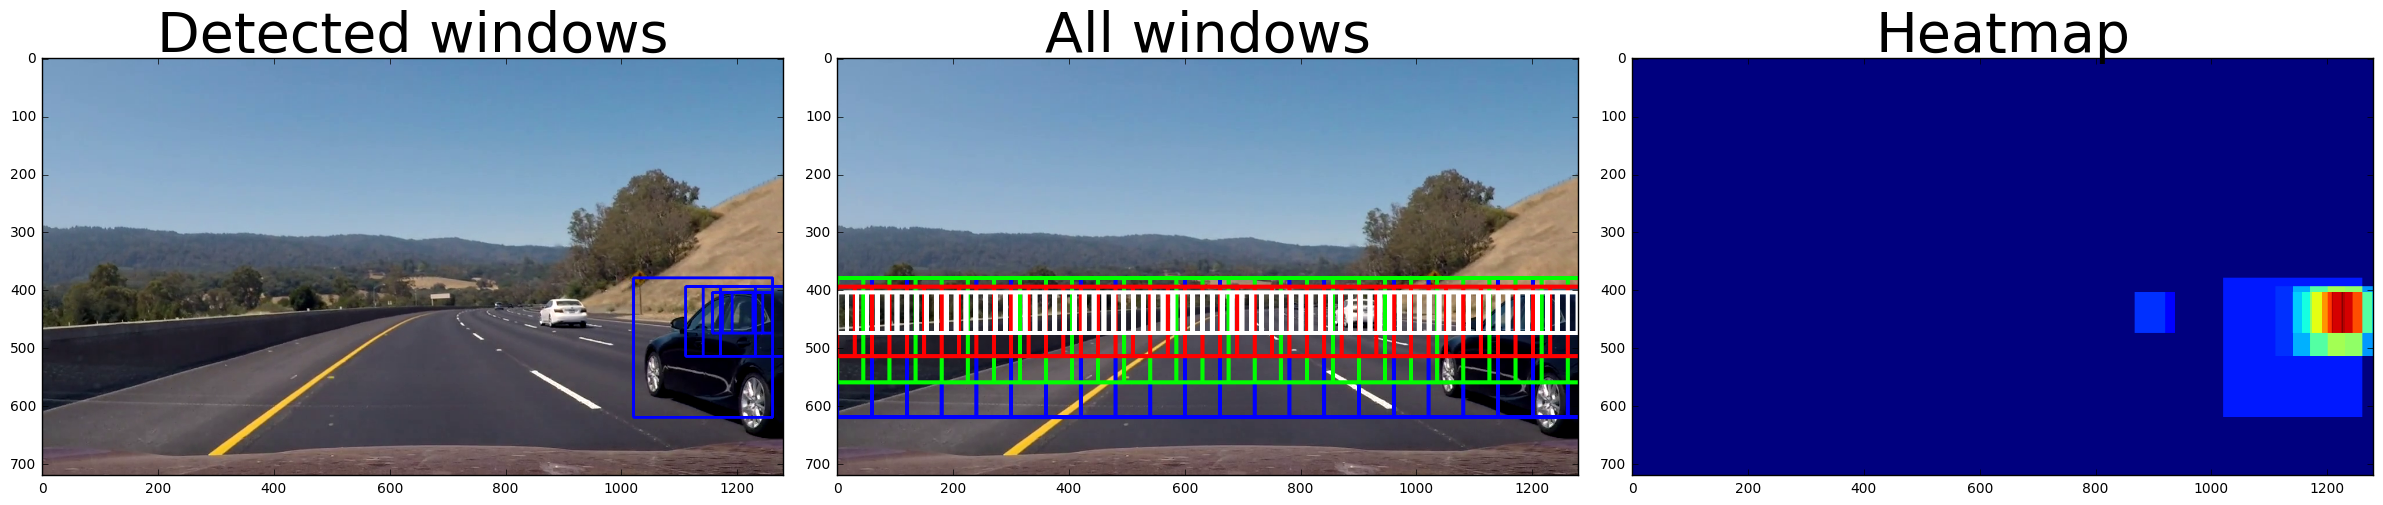

In [8]:
images = sorted(glob.glob('./heatmap/*.png'))
boxes = BoundingBoxes(n=6)

for file in images[30:36]:
    image = mpimg.imread(file)
    #image = image.astype(np.float32)/255
    draw_image = np.copy(image)

    t=time.time()
    hot_windows,all_windows = search_all_scales(image)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to search windows ...')
    
    boxes.update(hot_windows)
    
    #print(np.array(all_windows).shape)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)                    
    
    allwindows_img = draw_image
    for ind,win_list in enumerate(all_windows):
        if ind==0: color= (0,0,1)
        if ind==1: color= (0,1,0)
        if ind==2: color= (1,0,0)
        if ind==3: color= (1,1,1)
            
        allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)                    
    
    
    # Read in the last image shown above 
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap  = apply_threshold(heatmap,3)
    
    plt.figure()    
    # Plot the result
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(window_img)
    ax1.set_title('Detected windows', fontsize=40)

    ax2.imshow(allwindows_img)
    ax2.set_title('All windows', fontsize=40)
    
    ax3.imshow(heatmap)
    ax3.set_title('Heatmap', fontsize=40)

plt.show()

2 cars found


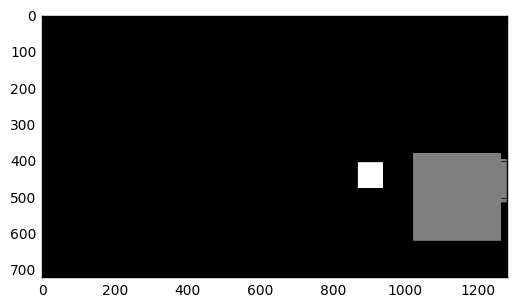

In [9]:
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

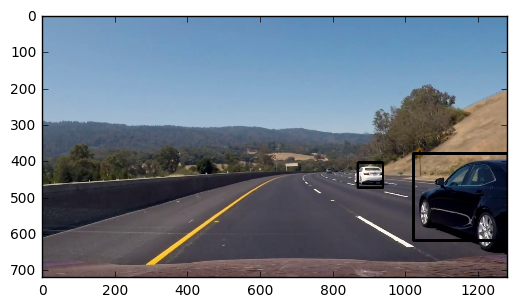

In [10]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Read in the last image above
image = mpimg.imread(images[36])
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)
plt.show()

In [13]:
boxes = BoundingBoxes(n=30)

def process_image(image):
    draw_image = np.copy(image)    
    image = image.astype(np.float32)/255
    hot_windows,_ = search_all_scales(image)
    boxes.update(hot_windows)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap  = apply_threshold(heatmap,15)
    labels = label(heatmap)
    
    window_image = draw_labeled_bboxes(draw_image, labels)
    
    #window_image = draw_boxes(draw_image, hot_windows, color=(0,0,255), thick=6)
    return window_image

In [14]:
out_dir='./output_images/'
inpfile='project_video.mp4'
outfile=out_dir+'processed_'+inpfile
clip = VideoFileClip(inpfile)
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(outfile, audio=False)


[MoviePy] >>>> Building video ./output_images/processed_project_video.mp4
[MoviePy] Writing video ./output_images/processed_project_video.mp4


100%|█████████▉| 1260/1261 [11:27<00:00,  1.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/processed_project_video.mp4 

CPU times: user 11min 25s, sys: 1.94 s, total: 11min 27s
Wall time: 11min 28s


## Images for Readme

In [ ]:
heatmap_images = sorted(glob.glob('./heatmap/*.png'))
boxes = BoundingBoxes(n=6)

fig, axes = plt.subplots(6,2,figsize=(15,30))
fig.subplots_adjust(hspace=0.1, wspace=0.05)
    
image_seq = heatmap_images[30:36]
final_heatmap = None

for ind,file in enumerate(image_seq):
    image = mpimg.imread(file)
    draw_image = np.copy(image)

    t=time.time()
    hot_windows,all_windows = search_all_scales(image)
    t2 = time.time()
    #print(round(t2-t, 2), 'Seconds to search windows ...')    
    boxes.update(hot_windows)
    
    #print(np.array(all_windows).shape)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)                    
            
    # Read in the last image shown above 
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap = apply_threshold(heatmap,3)
    final_heatmap = heatmap
    
    axes[ind,0].imshow(window_img)
    title = "frame {0}".format(ind)
    axes[ind,0].set_title(title, fontsize = 20)
    axes[ind,0].set_xticks([])
    axes[ind,0].set_yticks([])     

    
    axes[ind,1].imshow(heatmap)
    title = "heatmap {0}".format(ind)
    axes[ind,1].set_title(title, fontsize = 20)
    axes[ind,1].set_xticks([])
    axes[ind,1].set_yticks([])     

    
plt.savefig('images/heatmap.png')    

In [ ]:
plt.figure()
labels = label(final_heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.savefig('images/labels.png')

In [ ]:
# Read in the last image above
image = mpimg.imread(image_seq[-1])
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.xticks([])
plt.yticks([])
plt.imshow(draw_img)
#plt.show()
plt.savefig('images/bounding_boxes.png')